In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# COVID-19 Data Analysis with LSTM Models

# This notebook contains functions to analyze COVID-19 data and predict cases using LSTM models. It also provides functions for data preprocessing.

## Dependencies
# Make sure to install the required dependencies:

# ```python
!pip install pandas matplotlib numpy tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


2024-05-07 15:28:12.341765: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd

def parse_JHU_data():
    JHU_file = 'data/time_series_covid19_confirmed_US.csv'
    case_df = pd.read_csv(JHU_file)
    states = sorted(set(case_df['Province_State']))
    state_data = pd.DataFrame()
    for state in states:
        state_rows = case_df[case_df['Province_State'] == state]
        state_rows = state_rows.loc[:, '1/22/20':]

        state_data[state] = state_rows.sum()

    state_data = state_data.reset_index().rename(columns={'index': 'date'}).set_index('date')
    state_data.to_csv('data/state_cumulative.csv')
    daily_data = state_data.diff().iloc[1:]
    daily_data.to_csv('data/state_daily.csv')


In [19]:
def simple_LSTM():
    # from tensorflow import keras
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, LSTM, Bidirectional
    from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
    from tensorflow.keras.regularizers import l2
    from tensorflow.keras.callbacks import EarlyStopping
    from sklearn.preprocessing import StandardScaler

    state, state_short = 'Texas', 'TX'
    daily_file = 'data/state_daily.csv'
    daily_df = pd.read_csv(daily_file)
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    daily_df = daily_df[['date', state]]
    moving_avg = daily_df[state].rolling(window=7).mean().iloc[6:]
    daily_df[state] = moving_avg

    mobility_file = 'data/mobility.csv'
    mobility_df = pd.read_csv(mobility_file)
    mobility_df['date'] = pd.to_datetime(mobility_df['date'])
    mobility_df = mobility_df[mobility_df['state'] == state_short]
    mobility_df.drop(columns=['state'], inplace=True)

    tweet_file = 'data/parseTwitterData.csv'
    tweet_df = pd.read_csv(tweet_file)
    tweet_df.rename(columns={'Date': 'date'}, inplace=True)
    tweet_df['date'] = pd.to_datetime(tweet_df['date'])
    tweet_df = tweet_df[tweet_df['State'] == state_short]
    tweet_df = tweet_df[
        ['date', 'StringencyIndex_WeightedAverage',
         'Tweet_CPL', 'Tweet_AS', 'Reply_swear', 'Reply_emo_anger']]

    X = daily_df.copy()
    X = pd.merge(X, mobility_df, on='date', how='outer')
    X = pd.merge(X, tweet_df, on='date', how='outer')

    # add lagged Y columns
    prediction_length = 7
    for i in range(prediction_length):
        X[f'Y{i}'] = X[state].shift(-i)

    X.dropna(inplace=True)
    display(X[X[state] <= 0])
    dates = X['date']
    X.drop(columns=['date'], inplace=True)

    # select the target columns
    Y = X.iloc[:, -prediction_length:].values
    # drop the target
    X = X.iloc[:, :-prediction_length]
    n_features = X.shape[-1]
    X = X.values
    X_train, X_CV = X[:450], X[450:]
    Y_train, Y_CV = Y[:450], Y[450:]
    dates_train, dates_CV = dates[:450], dates[450:]

    window_size = 14
    generator_train = TimeseriesGenerator(X_train, Y_train, length=window_size)
    generator_CV = TimeseriesGenerator(X_CV, Y_CV, length=window_size)

    model = Sequential()
    model.add(Bidirectional(LSTM(64,
                                 activation='relu',
                                 input_shape=(window_size, n_features),
                                 kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)
                                 )))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dense(prediction_length))
    model.build(input_shape=(None, window_size, n_features))
    model.compile(optimizer='adam', loss='mape',  metrics=['accuracy'])
    model.summary()
    
    model.fit(generator_train, epochs=100, batch_size=100)
    Y_pred_train = model.predict(generator_train)
    Y_pred_CV = model.predict(generator_CV)

    display(len(Y_pred_CV))

    mean_sqr_error = np.mean(
        [np.abs(Y_train[window_size:] - Y_pred_train) / Y_train[window_size:]]
    )
    display('training MAPE:', f'{100 * mean_sqr_error:.4f}')

    mean_sqr_error = np.mean(
        [np.abs(Y_CV[window_size:] - Y_pred_CV) / Y_CV[window_size:]]
    )
    display('validation MAPE:', f'{100 * mean_sqr_error:.4f}')

    for i in range(prediction_length):
        fig = plt.figure()
        plt.figure(figsize=(12, 8))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.plot(dates_train[window_size:], Y_train[window_size:, i], label='Y')
        ax1.plot(dates_train[window_size:], Y_pred_train[:, i], label='prediction')
        ax1.legend()
        ax1.set_title('training')
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(dates_CV[window_size:], Y_CV[window_size:, i], label='Y')
        ax2.plot(dates_CV[window_size:], Y_pred_CV[:, i], label='prediction')
        ax2.legend()
        ax2.set_title('CV')
        fig.autofmt_xdate()
        plt.show()

    for i in range(7):
        fig = plt.figure()
        plt.figure(figsize=(12, 8))
        ax1 = fig.add_subplot()
        ax1.plot(dates_CV[window_size + i:window_size + i + prediction_length], Y_CV[window_size + i], label='Y')
        ax1.plot(dates_CV[window_size + i:window_size + i + prediction_length], Y_pred_CV[i], label='prediction')
        ax1.legend()
        fig.autofmt_xdate()
        plt.show()
        plt.close(fig)


In [20]:
def parse_mobility():
    mobility_files = ['data/Mobility/2020_US_Region_Mobility_Report.csv',
                      'data/Mobility/2021_US_Region_Mobility_Report.csv',
                      'data/Mobility/2022_US_Region_Mobility_Report.csv']
    mobility_df = pd.DataFrame()
    for file in mobility_files:
        df = pd.read_csv(file)
        cols_to_read = [5] + list(range(8, len(df.columns)))
        df = df.iloc[:, cols_to_read]
        df.iloc[:, 0] = df.iloc[:, 0].astype(str)
        # df.iloc[:, 1] = pd.to_datetime((df.iloc[:, 1]))
        mobility_df = pd.concat([mobility_df, df], ignore_index=True)

    print(mobility_df.info())
    mobility_df.rename(columns={mobility_df.columns[0]: 'state'}, inplace=True)
    mobility_df = mobility_df[mobility_df['state'] != 'nan']
    mobility_df['state'] = mobility_df['state'].apply(lambda x: x[3:])
    mobility_df.to_csv('data/mobility.csv', index=False)

In [21]:
def tmp():
    daily_file = 'data/state_daily.csv'
    daily_df = pd.read_csv(daily_file)
    daily_df['date'] = pd.to_datetime(daily_df['date'])
    daily_df = daily_df[['date', 'Illinois']]
    moving_avg = daily_df['Illinois'].rolling(window=7).mean().iloc[6:]
    daily_df['Illinois'] = moving_avg

    mobility_file = 'data/mobility.csv'
    mobility_df = pd.read_csv(mobility_file)
    mobility_df['date'] = pd.to_datetime(mobility_df['date'])
    mobility_df = mobility_df[mobility_df['state'] == 'IL']
    mobility_df.drop(columns=['state'], inplace=True)

    tweet_file = 'data/parseTwitterData.csv'
    tweet_df = pd.read_csv(tweet_file)
    tweet_df.rename(columns={'Date': 'date'}, inplace=True)
    tweet_df['date'] = pd.to_datetime(tweet_df['date'])
    tweet_df = tweet_df[tweet_df['State'] == 'IL']
    tweet_df = tweet_df[
        ['date', 'StringencyIndex_WeightedAverage', 'Tweet_CPL', 'Tweet_AS', 'Reply_swear', 'Reply_emo_anger']]

    X = pd.merge(daily_df, mobility_df, on='date', how='outer')
    X = pd.merge(X, tweet_df, on='date', how='outer')
    # scaler = StandardScaler()
    # scaler.fit(daily_df)
    X_states = ['Illinois', 'Indiana', 'Ohio', 'Wisconsin']
    # X_states = ['Illinois']
    # Y_states = ['Wisconsin']
    Y_states = ['Illinois']
    n_features = X.shape[-1]
    X.dropna(inplace=True)
    print(X.head())
    Y = X['Illinois'].copy()
    print(X.shape, Y.shape)

In [22]:
def parseTwitterData():
    twitterData = pd.read_csv('data/parseTwitterData.csv')
    print(twitterData.info())

,date,Texas,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,StringencyIndex_WeightedAverage,Tweet_CPL,Tweet_AS,Reply_swear,Reply_emo_anger,Y0,Y1,Y2,Y3,Y4,Y5,Y6
38,2020-03-01,0.0,14.0,9.0,6.0,7.0,2.0,-2.0,8.33,0.0,0.000000,0.201081,0.000000,0.0,0.000000,0.000000,0.000000,0.428571,0.571429,1.142857
39,2020-03-02,0.0,8.0,7.0,8.0,4.0,4.0,-1.0,8.33,0.0,0.000000,0.546068,0.113182,0.0,0.000000,0.000000,0.428571,0.571429,1.142857,1.571429
40,2020-03-03,0.0,12.0,10.0,17.0,3.0,3.0,-2.0,8.33,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.428571,0.571429,1.142857,1.571429,1.857143
41,2020-03-04,0.0,6.0,5.0,-10.0,0.0,2.0,1.0,8.33,0.0,1.803333,0.017818,0.024242,0.0,0.428571,0.571429,1.142857,1.571429,1.857143,2.285714


/var/folders/2b/plbxwf9x7tqgwmt4cprb18f80000gn/T/ipykernel_52345/3147703439.py:55: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  dates_train, dates_CV = dates[:450], dates[450:]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 128)              39424     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 7)                 455       
                                                                 
Total params: 48,135
Trainable params: 48,135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


2024-05-07 15:32:37.125482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 3s 20ms/step - loss: 99.8317 - accuracy: 0.1216
Epoch 2/100
4/4 [==============================] - 0s 14ms/step - loss: 76.8637 - accuracy: 0.1330
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 63.3154 - accuracy: 0.0872
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 55.5073 - accuracy: 0.0917
Epoch 5/100
4/4 [==============================] - 0s 13ms/step - loss: 50.2245 - accuracy: 0.1032
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 44.7638 - accuracy: 0.1261
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 42.1899 - accuracy: 0.0917
Epoch 8/100
4/4 [==============================] - 0s 14ms/step - loss: 38.5264 - accuracy: 0.0894
Epoch 9/100
4/4 [==============================] - 0s 14ms/step - loss: 39.3704 - accuracy: 0.1307
Epoch 10/100
4/4 [==============================] - 0s 16ms/step - loss: 34.1989 - accuracy: 0.1468
Epoch 11/100
4/4 [===

4/4 [==============================] - 0s 19ms/step - loss: 19.0217 - accuracy: 0.1995
Epoch 84/100
4/4 [==============================] - 0s 17ms/step - loss: 20.0958 - accuracy: 0.2408
Epoch 85/100
4/4 [==============================] - 0s 14ms/step - loss: 19.4146 - accuracy: 0.2225
Epoch 86/100
4/4 [==============================] - 0s 13ms/step - loss: 20.1237 - accuracy: 0.1904
Epoch 87/100
4/4 [==============================] - 0s 15ms/step - loss: 20.0523 - accuracy: 0.1904
Epoch 88/100
4/4 [==============================] - 0s 16ms/step - loss: 20.8047 - accuracy: 0.2087
Epoch 89/100
4/4 [==============================] - 0s 15ms/step - loss: 21.9664 - accuracy: 0.1927
Epoch 90/100
4/4 [==============================] - 0s 14ms/step - loss: 20.0048 - accuracy: 0.2638
Epoch 91/100
4/4 [==============================] - 0s 15ms/step - loss: 18.1037 - accuracy: 0.2523
Epoch 92/100
4/4 [==============================] - 0s 14ms/step - loss: 17.8509 - accuracy: 0.1743
Epoch 93/100


2024-05-07 15:32:49.060152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


2/2 [==============================] - 0s 5ms/step


2024-05-07 15:32:49.523001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


146

'training MAPE:'

'16.2315'

'validation MAPE:'

'18.8979'

/var/folders/2b/plbxwf9x7tqgwmt4cprb18f80000gn/T/ipykernel_52345/3147703439.py:93: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax1.plot(dates_train[window_size:], Y_train[window_size:, i], label='Y')
/var/folders/2b/plbxwf9x7tqgwmt4cprb18f80000gn/T/ipykernel_52345/3147703439.py:94: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax1.plot(dates_train[window_size:], Y_pred_train[:, i], label='prediction')
/var/folders/2b/plbxwf9x7tqgwmt4cprb18f80000gn/T/ipykernel_52345/3147703439.p

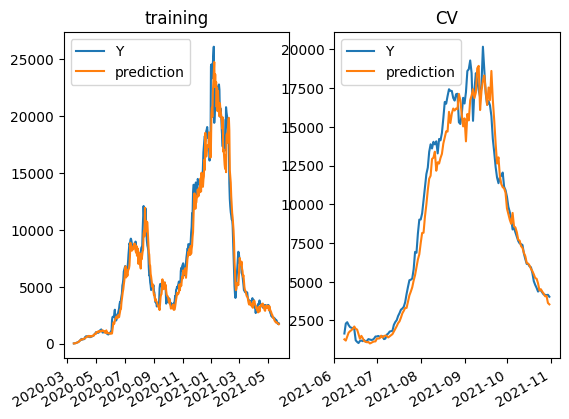

<Figure size 1200x800 with 0 Axes>

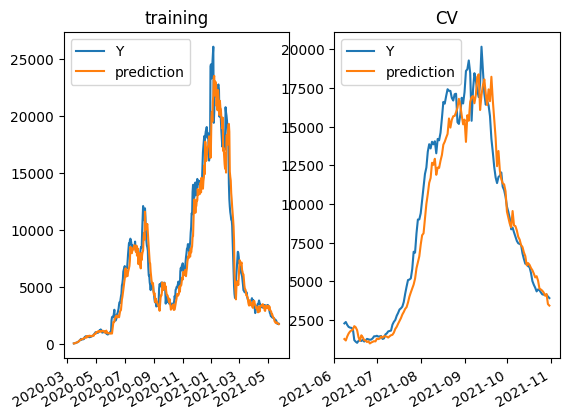

<Figure size 1200x800 with 0 Axes>

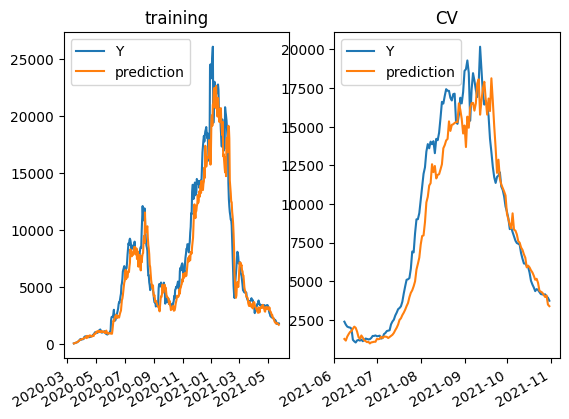

<Figure size 1200x800 with 0 Axes>

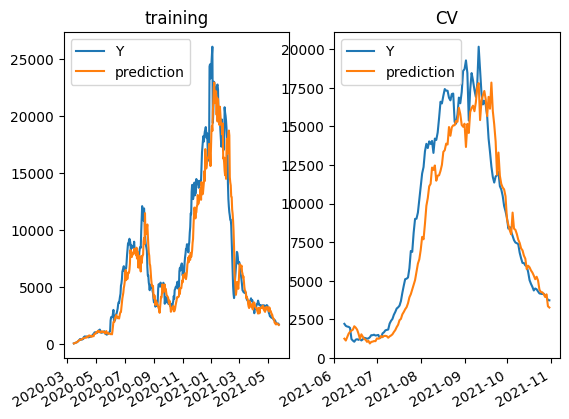

<Figure size 1200x800 with 0 Axes>

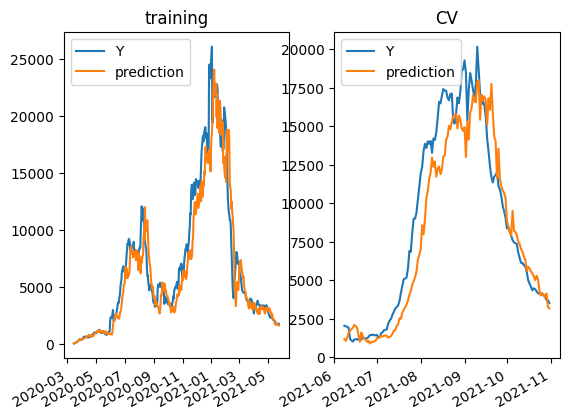

<Figure size 1200x800 with 0 Axes>

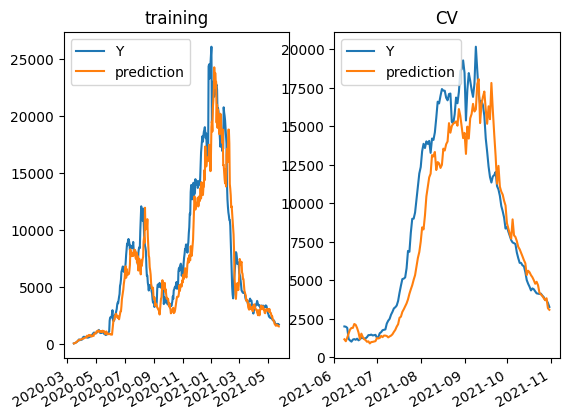

<Figure size 1200x800 with 0 Axes>

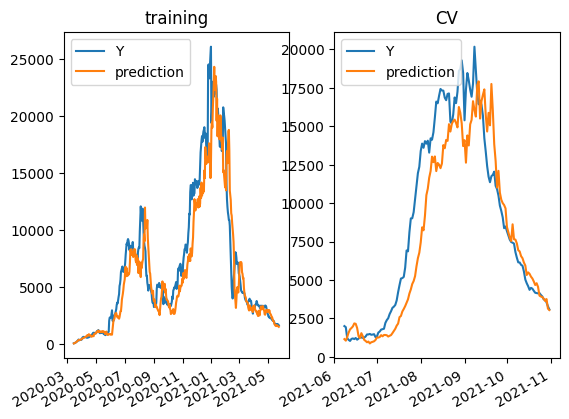

<Figure size 1200x800 with 0 Axes>

/var/folders/2b/plbxwf9x7tqgwmt4cprb18f80000gn/T/ipykernel_52345/3147703439.py:109: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax1.plot(dates_CV[window_size + i:window_size + i + prediction_length], Y_CV[window_size + i], label='Y')
/var/folders/2b/plbxwf9x7tqgwmt4cprb18f80000gn/T/ipykernel_52345/3147703439.py:110: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax1.plot(dates_CV[window_size + i:window_size + i + prediction_length], Y_pred_CV[i], label='prediction')


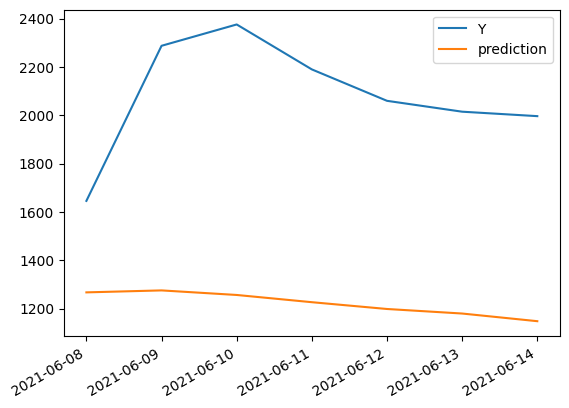

<Figure size 1200x800 with 0 Axes>

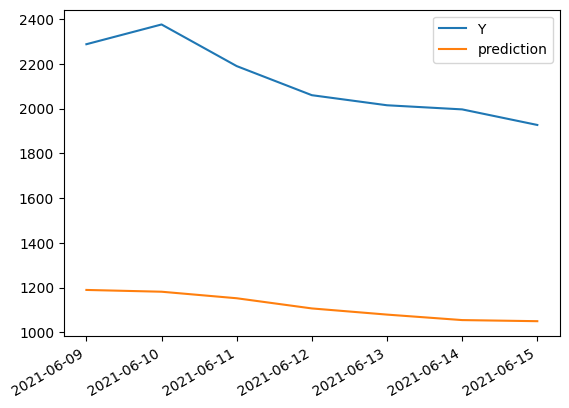

<Figure size 1200x800 with 0 Axes>

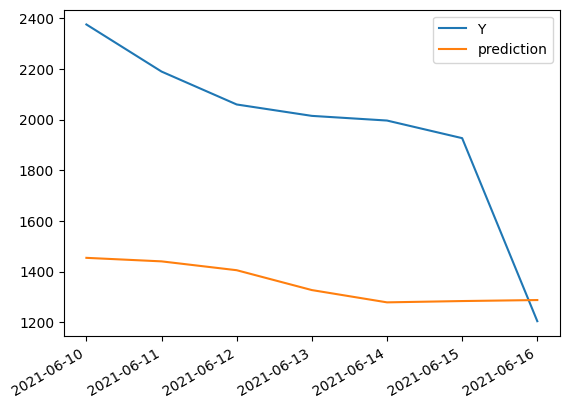

<Figure size 1200x800 with 0 Axes>

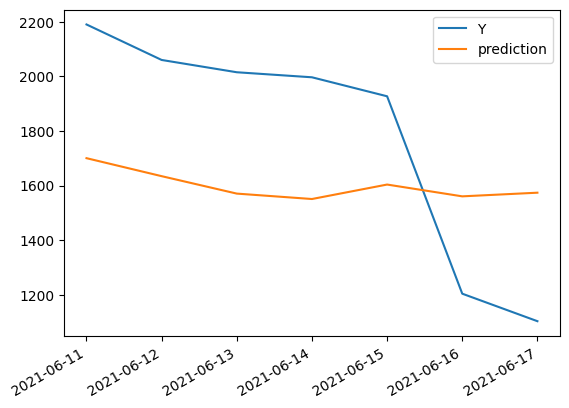

<Figure size 1200x800 with 0 Axes>

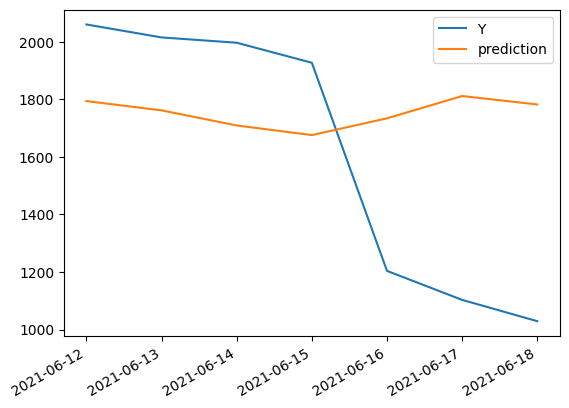

<Figure size 1200x800 with 0 Axes>

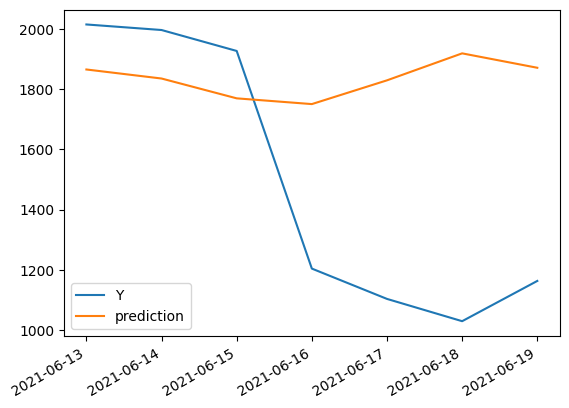

<Figure size 1200x800 with 0 Axes>

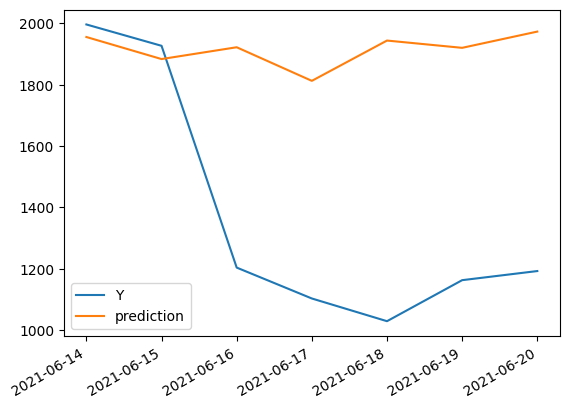

<Figure size 1200x800 with 0 Axes>

In [23]:
simple_LSTM()